<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/Customer_Segmentation_and_Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
import os, warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [ ]:
init_notebook_mode(connected=True)
color=px.colors.qualitative.Plotly
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

In [ ]:

cust = pd.read_csv('/gdrive/MyDrive/Customer Segmentation and Clustering Analysis/Mall_Customers.csv')
cust.rename(columns={"Annual Income (k$)": "Annual Income", "Spending Score (1-100)": "Spending Score"}, inplace=True)
print("There are {:,} observations and {} columns in the data set.".format(cust.shape[0], cust.shape[1]))
print("There are {} missing values in the data.".format(cust.isna().sum().sum()))
cust.head()

There are 200 observations and 5 columns in the data set.
There are 0 missing values in the data.


,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
cust.drop('CustomerID', axis=1, inplace=True)
pd.DataFrame(cust.describe()).style.set_caption("Summary Statistics of Numeric Variables")

,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [ ]:
cust['Gender'] = ['Women' if i == 'Female' else 'Men' for i in cust.Gender]
pd.DataFrame(cust.select_dtypes('object').describe().T).style.set_caption("Summary Statistics of Categorical Variables")

,count,unique,top,freq
Gender,200,2,Women,112


Exploratory Data Analysis

In [ ]:
init_notebook_mode(connected=True)
plot_df=cust.copy()
plot_df['Annual Income']=plot_df['Annual Income'].mul(1000)
p1=plot_df.groupby('Gender')['Age'].mean().round(0).astype(int).reset_index()
p2=plot_df.groupby('Gender')['Annual Income'].mean().reset_index()
p3=plot_df.groupby('Gender')['Spending Score'].mean().round(0).astype(int).reset_index()

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=("Distribution of Age<br>by Gender", 
                                    "Customers Average Age",
                                    "Distribution of Income<br>by Gender", 
                                    "Customers Average Income",
                                    "Distribution of Spending<br>by Gender", 
                                    "Customers Average Spending")
                   )

fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Men']['Age'], histnorm='probability density', 
                           marker=dict(color='#508B8D',opacity=0.7, line=dict(width=1, color='#000000')), 
                           nbinsx=20, name="Men"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Women']['Age'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB',opacity=0.7, line=dict(width=1, color='#000000')),
                           nbinsx=20, name="Women"),
              row=1, col=1)

fig.add_trace(go.Bar(x=p1['Gender'], y=p1['Age'], text=p1['Age'], texttemplate='%{text} years', textposition='outside',
                     marker=dict(color=['#508B8D', '#F0CABD'], opacity=0.8),width=.8,
                     hovertemplate='Average Age Among %{x} = %{y} years<extra></extra>', showlegend=False),
              row=1, col=2)

fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Men']['Annual Income'], histnorm='probability density', 
                           marker=dict(color='#508B8D', line=dict(width=1, color='#000000')), 
                           opacity=0.7, name="Men", nbinsx=20, showlegend=False),
              row=2, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Women']['Annual Income'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Women", nbinsx=20, showlegend=False),
              row=2, col=1)
fig.add_trace(go.Bar(x=p2['Gender'], y=p2['Annual Income'], text=p2['Annual Income'], 
                     texttemplate='$%{text:,.0f}', textposition='outside',
                     marker=dict(color=['#508B8D', '#F0CABD'], opacity=0.8),width=.8,
                     hovertemplate='Average Income Among %{x} = $%{y}<extra></extra>', showlegend=False),
              row=2, col=2)
fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Men']['Spending Score'], histnorm='probability density', 
                           marker=dict(color='#508B8D', line=dict(width=1, color='#000000')), 
                           opacity=0.7, name="Men", nbinsx=20, showlegend=False),
              row=3, col=1)
fig.add_trace(go.Histogram(x=plot_df[plot_df.Gender=='Women']['Spending Score'], histnorm='probability density', 
                           marker=dict(color='#F3D6CB', line=dict(width=1, color='#000000')),
                           opacity=0.7, name="Women", nbinsx=20, showlegend=False),
              row=3, col=1)
fig.add_trace(go.Bar(x=p3['Gender'], y=p3['Spending Score'], text=p3['Spending Score'], 
                     texttemplate='%{text}', textposition='outside',
                     marker=dict(color=['#508B8D', '#F0CABD'], opacity=0.8),width=.8,
                     hovertemplate='Average Spending Score Among %{x} = %{y}<extra></extra>', showlegend=False),
              row=3, col=2)
fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(template=temp,barmode='overlay', height=1500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", xanchor="right", y=1.03, x=.97),
                  xaxis1_title="Age", yaxis1_title='Probability Density', 
                  xaxis2_title="Gender", yaxis2_title="Age", yaxis2_range=[0,45],
                  xaxis3_title="Annual Income, $", yaxis3_title='Probability Density', 
                  xaxis4_title="Gender", yaxis4_title="Annual Income, $", yaxis4_range=[0,69e3],
                  xaxis5_title="Spending Score", yaxis5_title='Probability Density', 
                  xaxis6_title="Gender", yaxis6_title="Spending Score", yaxis6_range=[0,59]
                 )
fig.show(renderer="colab")

# Pairplots
fig = ff.create_scatterplotmatrix(cust, diag='box', index='Gender', colormap=['#508B8D', '#F0CABD']) 
fig.update_traces(marker=dict(size=9, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(title="Mall Customer Pair Plots", template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, x=.35),
                  height=900, width=700)
fig.show(renderer="colab")

# Correlations
corr=cust.corr()
x = corr.columns.tolist() 
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='mint', 
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")
fig.update_layout(template=temp, title="Mall Customer Correlations", yaxis_tickangle=-30)
fig.show(renderer="colab")


K-Means Clustering

The first clustering technique I will explore is K-Means Clustering. K-Means Clustering is a simple yet powerful clustering method that creates  k  distinct segments of the data where the variation within the clusters is as small as possible. To find the optimal number of clusters, I will try different values of  k  and calculate the inertia, or distortion score, for each model. Inertia measures the cluster similarity by computing the total distance between the data points and their closest cluster center. Clusters with similar observations tend to have smaller distances between them and a lower distortion score overall.

In [ ]:
# K-Means Clustering
clust_df = cust.copy()
clust_df['Gender'] = [1 if i == "Women" else 0 for i in clust_df.Gender]

k_means = list()
for clust in range(1,16):
    km = KMeans(n_clusters=clust, init='k-means++', random_state=21).fit(clust_df)
    k_means.append(pd.Series({'Clusters': clust, 
                              'Inertia': km.inertia_,
                              'model': km}))

# Plot results
plot_km = (pd.concat(k_means, axis=1).T
           [['Clusters','Inertia']]
           .set_index('Clusters'))

fig = px.line(plot_km, x=plot_km.index, y='Inertia', markers=True)
fig.add_vline(x=5, line_width=3, line_dash="dash", line_color="darkgrey")
fig.add_annotation(
    xref="x domain",
    yref="y",
    x=.31,
    y=75e3,
    text="Optimal Number of Clusters",
    axref="x domain",
    ayref="y",
    ax=.43,
    ay=12e4,
    arrowhead=2, 
    bordercolor="#585858",
    borderpad=4, 
    bgcolor='white',
    font=dict(size=14)
)
fig.update_traces(line_color='#518C89')
fig.update_layout(template=temp, title="K-Means Clustering Elbow Curve", 
                  xaxis=dict(tickmode = 'linear', showline=True), yaxis=dict(showline=True), width=700)
fig.show(renderer="colab")

The graph above shows the inertia values for each K-Means model with clusters between 1 and 15. The inflection point in the graph occurs at about 5 clusters, where the inertia begins to plateau. This indicates that the optimal number of clusters,  k  is equal to 5. Below is a plot of the clusters based on their spending score and income.

In [ ]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(clust_df)
plot_km=clust_df.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="Spending Score", y="Annual Income", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Customer Spending vs. Income", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Spending Score', showline=True, zeroline=False), 
                  yaxis=dict(title='Income, $', ticksuffix='k', showline=True))
fig.show(renderer="colab")

The K-Means model segments the data into distinct clusters based on customer's spending and income. Cluster 0 in the center of the graph consists of customers with average spending scores, between 35-61, and incomes between $40,000 and $71,000. The two clusters on the left, Clusters 1 and 3, both identify customers with lower spending scores that are below 40 and subdivides the groups according to their income. In contrast, Clusters 2 and 4 consist of customers with higher spending scores, above 61, and are further partitioned based on their income.

Hierarchical Clustering

The next clustering method I will explore is hierarchical clustering. Using an agglomerative approach, hierarchical clustering joins groups of observations together from the bottom up, with each observation beginning its own cluster. The model then joins pairs of observations that are most similar to each other based on their Euclidean distance and iteratively combines cluster pairs based on the distances between the groups until all observations have been merged.

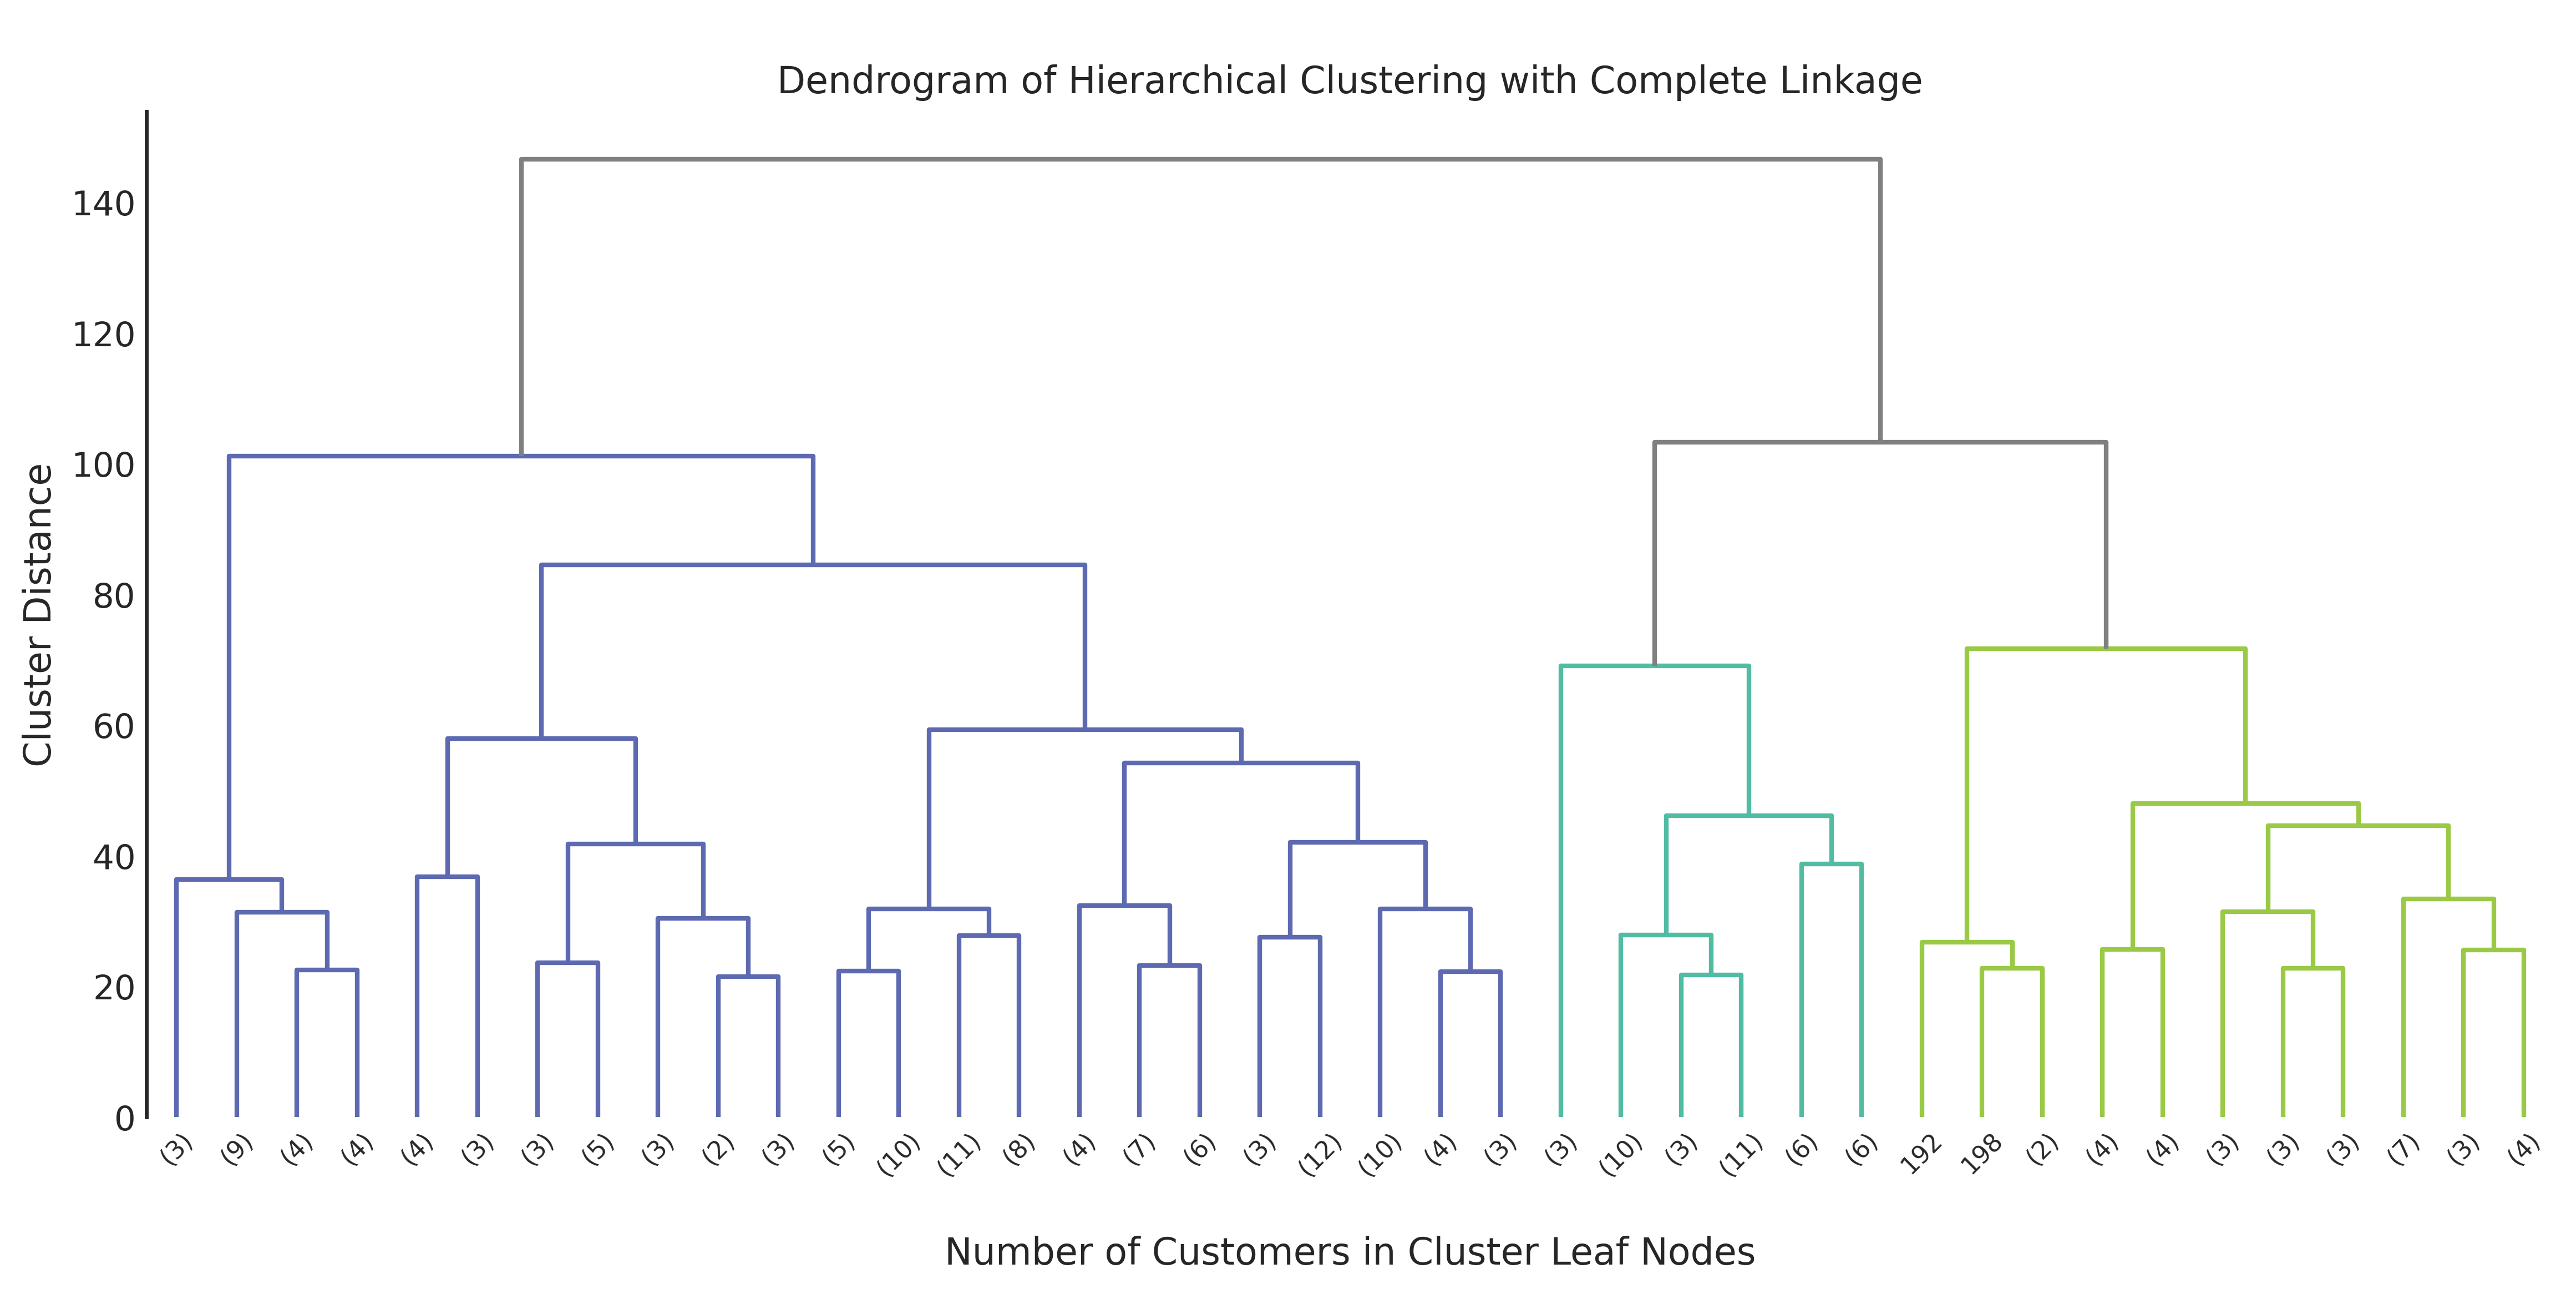

In [ ]:
sns.set(rc={'figure.dpi':400})
sns.set_context('notebook')
sns.set_style('ticks')

Z = hierarchy.linkage(clust_df, method='complete', metric='euclidean')
fig, ax = plt.subplots(figsize=(14,6))
hierarchy.set_link_color_palette(['#5d69b1', '#52bca3', '#99c945'])
den = hierarchy.dendrogram(Z, orientation='top', color_threshold=102,
                           p=40, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='grey')
#ax.axhline(101, color='grey', linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel('\nNumber of Customers in Cluster Leaf Nodes')
ax.set_ylabel('Cluster Distance')
ax.set_title('\nDendrogram of Hierarchical Clustering with Complete Linkage')
fig.show()

The dendrogram above shows the hierarchical clusters created using complete linkage, which joins pairs of clusters together that have the smallest maximum distance between their observations. The height at which the branches split indicates the distance between the clusters. Clusters that are more similar to each other are joined early on in the tree and become less and less similar as we move up the tree. To identify the number of clusters, we can make a horizontal cut across the dendrogram. For instance, if we were to cut the dendrogram at a height of 100, we would have about three clusters, with the majority of customers in the first cluster, colored purple. Let's look at the results of the hierarchical clustering based on customer's spending and income.

In [16]:
# Hierarchical clustering
hc = AgglomerativeClustering(3, affinity='euclidean', linkage='complete', compute_full_tree=False)
hc_pred = hc.fit_predict(clust_df)
plot_hc=clust_df.copy()
plot_hc["Hierarchical Cluster"]=hc_pred
plot_hc=plot_hc.sort_values(by='Hierarchical Cluster')
plot_hc['Hierarchical Cluster'] = plot_hc['Hierarchical Cluster'].astype(str)

# Plot of clusters                                               
fig = px.scatter(plot_hc, x="Spending Score", y="Annual Income", color="Hierarchical Cluster",
                 color_discrete_sequence=px.colors.qualitative.Vivid[1:])
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="Hierarchical Cluster Profiles,<br>Customer Spending vs. Income", 
                  width=700, legend_title = 'Cluster',
                  xaxis=dict(title='Spending Score',showline=True, zeroline=False), 
                  yaxis=dict(title='Income, $',ticksuffix='k',showline=True))
fig.show(renderer="colab")


Hierarchical clustering tends to put more weight on customer's income in creating the clusters. The largest cluster, Cluster 0, consists of customers who have an annual income of around $70,000 or less and spending scores ranging from 3 to 99, while customers in Clusters 1 and 2 have incomes above $70,000 and are further subdivided into smaller segments based on their spending score.

DBSCAN

The next clustering technique I will try is Density-Based Spatial Clustering of Applications with Noise (DBSCAN). DBSCAN segments the data based on the density of observations, where areas of high density are separated from areas of low density. The model can also identify uniquely-shaped clusters and detect outliers within the data, although it is sensitive to varying densities of observations.

In [18]:
# DB Scan clustering
db=DBSCAN(eps=15, min_samples=11, metric='euclidean')  #17,15 14,7 12 7 115
db_preds=db.fit_predict(clust_df)
plot_db=clust_df.copy()
plot_db['DB Cluster'] = db_preds
plot_db=plot_db.sort_values(by='DB Cluster')
plot_db['DB Cluster'] = plot_db['DB Cluster'].astype(str).apply(lambda x: 'Outliers' if x == '-1' else x)


# Plot of clusters   
fig = px.scatter(plot_db, x="Spending Score", y="Annual Income", color="DB Cluster",
                 color_discrete_sequence=px.colors.qualitative.T10[2:])
fig.update_traces(marker=dict(size=11, opacity=0.85, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="DBSCAN Cluster Profiles,<br>Customer Spending vs. Income", 
                  width=700, legend_title = 'Cluster',
                  xaxis=dict(title='Spending Score',showline=True, zeroline=False), 
                  yaxis=dict(title='Income, $',ticksuffix='k',showline=True))
fig.show(renderer="colab")

The DBSCAN model with a local radius of 15 segments the data into four clusters. These segments resemble the clusters from the K-Means model, with the outliers identified in red. Overall, there are quite a few outliers in the graph, which is likely due to the variation in the densities of the clusters.

Cluster Profile Comparison

In [19]:
# Initializing figure with 3 3D subplots
fig = make_subplots(rows=3, cols=1,
                    vertical_spacing=0.1,
                    specs=[[{'type': 'scatter3d'}],
                           [{'type': 'scatter3d'}], 
                           [{'type': 'scatter3d'}]],
                     subplot_titles=("K-Means Clustering with 5 clusters", 
                                     "Hierarchical Clustering<br>with 3 clusters", 
                                     "DBSCAN<br>with 4 clusters")
                   )

# Adding clusters to scatterplots 
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(int)
plot_km=plot_km.sort_values(by='K-Means Cluster')
for i in range(0,5):
    fig.add_trace(go.Scatter3d(x = plot_km[plot_km['K-Means Cluster'] == i]['Spending Score'],
                               y = plot_km[plot_km['K-Means Cluster'] == i]['Age'],
                               z = plot_km[plot_km['K-Means Cluster'] == i]['Annual Income'],                        
                               mode = 'markers', marker=dict(
                                   size=7,  
                                   color = px.colors.qualitative.Prism[i],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.7),
                               name = str('Cluster '+str(i)), legendgroup = 1),
                 row=1, col=1)

plot_hc['Hierarchical Cluster'] = plot_hc['Hierarchical Cluster'].astype(int)
plot_hc=plot_hc.sort_values(by='Hierarchical Cluster')
for i in range(0,3):    
    fig.add_trace(go.Scatter3d(x = plot_hc[plot_hc['Hierarchical Cluster'] == i]['Spending Score'],
                               y = plot_hc[plot_hc['Hierarchical Cluster'] == i]['Age'],
                               z = plot_hc[plot_hc['Hierarchical Cluster'] == i]['Annual Income'],                        
                               mode = 'markers', marker=dict(
                                   size=7,   
                                   color = px.colors.qualitative.Vivid[i+1],
                                   line_width = 1, 
                                   line_color='#F7F7F7',
                                   opacity=0.7),
                               name = str('Hierarchical Cluster '+str(i)), legendgroup = 2), 
                  row=2, col=1)

for i, j in enumerate(plot_db['DB Cluster'].unique()): 
    fig.add_trace(go.Scatter3d(x = plot_db[plot_db['DB Cluster'] == j]['Spending Score'],
                               y = plot_db[plot_db['DB Cluster'] == j]['Age'],
                               z = plot_db[plot_db['DB Cluster'] == j]['Annual Income'], 
                               mode = 'markers', marker=dict(
                                   size=7,   
                                   color = px.colors.qualitative.T10[i+2],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.8),
                               name = str('DB Cluster '+str(j)), legendgroup = 3), 
                  row=3, col=1)

fig.update_traces(hovertemplate='Customer Spending Score: %{x}<br>Income: $%{z}<br>Age: %{y}')
fig.update_layout(title="Customer Segments based on Income, Spending, and Age",
                  template=temp, height=1800, legend_tracegroupgap = 500,
                  scene=dict(aspectmode='cube',
                             xaxis = dict(title='Spending Score', 
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Age, in years',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='Income, $', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")), 
                  scene2=dict(aspectmode='cube', 
                             xaxis = dict(title='Spending Score',
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Age, in years',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='Income, $', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")), 
                  scene3=dict(aspectmode='cube', 
                             xaxis = dict(title='Spending Score',
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Age, in years',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='Income, $', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"))
                  )
fig.show(renderer="colab")